## House Prices Prediction - Model training with Automated Machine Learning and Model Explainability

### In this tutorial we will perform the same basic data preparation and model training steps as we did before, but know with the help of Azure ML service for Automated Machine Learning and Model Explainability.

#### We begin by importing the necessary packages and setting some notebook options.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os, logging

from azureml.core import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.core.experiment import Experiment
from azureml.widgets import RunDetails

from azureml.explain.model._internal.explanation_client import ExplanationClient
from azureml.train.automl.automl_explain_utilities import AutoMLExplainerSetupClass, automl_setup_model_explanations
from azureml.explain.model.mimic.models.lightgbm_model import LGBMExplainableModel
from azureml.explain.model.mimic_wrapper import MimicWrapper
from azureml.contrib.explain.model.visualize import ExplanationDashboard

warnings.filterwarnings('ignore')

%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

#### Here we are going to train locally. Therefore, instead of executing the data loading and preparation steps in a separate script, we just execute them here.

In [2]:
df_housing = pd.read_csv("./data/ames.csv")

df_housing.drop("Order", axis = 1, inplace = True)
df_housing.drop("PID", axis = 1, inplace = True)

fill_none = ["Pool.QC", "Misc.Feature", "Alley", "Fence", "Fireplace.Qu", "Garage.Type", "Garage.Finish", "Garage.Qual", "Garage.Cond",
            "Bsmt.Exposure", "Bsmt.Cond", "Bsmt.Qual", "Mas.Vnr.Type"]
for var in fill_none:
    df_housing[var] = df_housing[var].fillna("None")
    
fill_zero = ["Garage.Yr.Blt", "BsmtFin.Type.2", "BsmtFin.Type.1", "Bsmt.Half.Bath", "Bsmt.Full.Bath", "Total.Bsmt.SF",
             "Bsmt.Unf.SF", "BsmtFin.SF.1", "BsmtFin.SF.2", "Garage.Area", "Garage.Cars", "Mas.Vnr.Area"]
for var in fill_zero:
    df_housing[var] = df_housing[var].fillna(0)

df_housing["Lot.Frontage"] = df_housing.groupby("Neighborhood")["Lot.Frontage"].transform(lambda x: x.fillna(x.median()))

df_housing['Electrical'] = df_housing['Electrical'].fillna(df_housing['Electrical'].mode()[0])

df_housing = df_housing.dropna()

response_var = ["SalePrice"]

numeric_vars = ["Lot.Frontage", "Lot.Area", "Mas.Vnr.Area", "BsmtFin.SF.1", "BsmtFin.SF.2", "Bsmt.Unf.SF", "Total.Bsmt.SF",
                "X1st.Flr.SF", "X2nd.Flr.SF", "Low.Qual.Fin.SF", "Gr.Liv.Area", "Garage.Area", "Wood.Deck.SF",
                "Open.Porch.SF", "Enclosed.Porch", "X3Ssn.Porch", "Screen.Porch", "Pool.Area", "Misc.Val"]

categorical_vars = [v for v in df_housing.columns if v not in numeric_vars + response_var]

def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
categorical_vars_E = []
for q in categorical_vars:  
    encode(df_housing, q)
    df_housing[q+'_E'] = df_housing[q+'_E'].astype('int')
    categorical_vars_E.append(q+'_E')
    
X_train, X_test, y_train, y_test = train_test_split(df_housing[numeric_vars + categorical_vars_E], df_housing[response_var],
                                                    test_size=0.4, random_state=0)

#### Before running the next cell, we need to create an Azure ML service Workspace. Follow the instructions [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-workspace) and then download the config.json file. Then, upload that file to your config folder. You may skip this step, if you have already run it in the previous notebook.
#### Now we instantiate a [Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspaces) object, using the information from the configuration file that we uploaded previously.

In [3]:
ws = Workspace.from_config(path="./config/ws_config.json")

#### The first step before using [automated machine learning](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-automated-ml) is to define the configuration for the AutoML job submission.
#### This is done by creating a [AutoMLConfig](https://docs.microsoft.com/en-us/python/api/azureml-train-automl/azureml.train.automl.automlconfig?view=azure-ml-py) object.
#### There are several parameters in the [configuration](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train) that control the automated machine learning job execution, such as number of iterations, iteration timeout, primary model metric, and many others.
#### Here we are defining some of those parameters in a dictionary, to be later unpacked as arguments when creating the AutoMLConfig object.

In [4]:
automl_settings = {
    "iteration_timeout_minutes": 15,
    "iterations": 10,
    "primary_metric": "normalized_mean_absolute_error",
    "preprocess": True,
    "verbosity": logging.INFO,
    "n_cross_validations": 5,
    "model_explainability": True
}

In [5]:
automl_config = AutoMLConfig(task="regression",
                             debug_log="automated_ml_errors.log",
                             X=X_train,
                             y=y_train,
                             **automl_settings)

#### Next, we instantiate an [Experiment](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiments) object and then submit our automated machine learning job for execution, passing the AutoMLConfig object created before.

In [6]:
experiment = Experiment(ws, "house_prices_autoML")
local_run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_8eee9afc-a9e9-4a9e-b0b7-1ff557930988
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS SUMMARY:
For more details, use API: run.get_guardrails()

TYPE:         Missing Values Imputation
STATUS:       PASSED
DESCRIPTION:  There were no missing values found in the training data.

TYPE:         High Cardinality Feature Detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and no high cardinality features were detected.

**************************************************************

#### We can monitor the execution through a Jupyter [graphical widget](https://docs.microsoft.com/en-us/azure/machine-learning/service/tutorial-auto-train-models#explore-the-results), available through the RunDetails class.

In [7]:
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

#### After the job is completed, we can access the best run and best trained model.
#### By printing the best trained model, we can see the [steps](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train#understand-automated-ml-models) that were automatically executed.

In [8]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: house_prices_autoML,
Id: AutoML_8eee9afc-a9e9-4a9e-b0b7-1ff557930988_8,
Type: None,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_feature_sweeping=None, feature_sweeping_timeout=None,
        featurization_config=None, is_cross_validation=None,
        is_onnx_compatible=None, jasmine_client=None, logger=None,
        observer=None,
        parent_run_id='AutoML_8eee9afc-a9e9-4... warm_start=False))]))],
               flatten_transform=None, weights=[0.1, 0.5, 0.1, 0.2, 0.1]))]),
          stddev=None)


#### Here we compute model performance metrics for train and test datasets.

In [9]:
def MAPE(y_actual, y_predict):
    sum_actuals = sum_errors = 0
    
    for actual_val, predict_val in zip(y_actual, y_predict):
        abs_error = actual_val - predict_val
        if abs_error < 0:
            abs_error = abs_error * -1

        sum_errors = sum_errors + abs_error
        sum_actuals = sum_actuals + actual_val

    return sum_errors / sum_actuals

y_pred_train = fitted_model.predict(X_train)
y_pred_test = fitted_model.predict(X_test)
y_true_train = y_train.values.flatten()
y_true_test = y_test.values.flatten()

print("MAPE (Train): %f" % MAPE(y_true_train, y_pred_train))
print("MAPE (Test): %f" % MAPE(y_true_test, y_pred_test))

print("Acc (Train): %f" % (1 - MAPE(y_true_train, y_pred_train)))
print("Acc (Test): %f" % (1 - MAPE(y_true_test, y_pred_test)))

print("MAE (Train): %f" % mean_absolute_error(y_true_train, y_pred_train))
print("MAE (Test): %f" % mean_absolute_error(y_true_test, y_pred_test))

print("R2 (Train): %f" % r2_score(y_true_train, y_pred_train))
print("R2 (Test): %f" % r2_score(y_true_test, y_pred_test))

MAPE (Train): 0.062423
MAPE (Test): 0.078582
Acc (Train): 0.937577
Acc (Test): 0.921418
MAE (Train): 11303.104597
MAE (Test): 14164.333857
R2 (Train): 0.950520
R2 (Test): 0.889472


#### Now let's visualize the plots for predicted versus actual values for both train and test datasets.

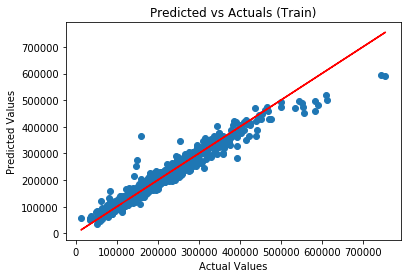

In [10]:
plt.scatter(y=y_pred_train, x=y_true_train)
plt.plot(y_true_train, y_true_train, color="red")
plt.title("Predicted vs Actuals (Train)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

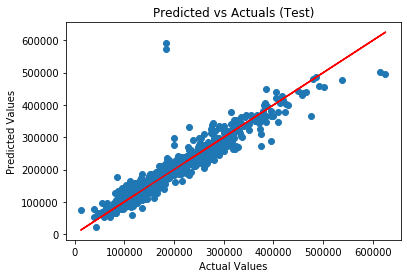

In [11]:
plt.scatter(y=y_pred_test, x=y_true_test)
plt.plot(y_true_test, y_true_test, color="red")
plt.title("Predicted vs Actuals (Test)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

#### Finally, let's plot the error distributions for both train and test datasets.

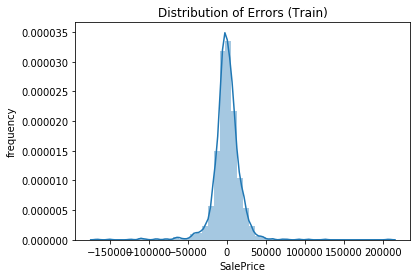

In [12]:
ax = sns.distplot(y_pred_train - y_true_train)
ax.set(title="Distribution of Errors (Train)", xlabel="SalePrice", ylabel="frequency")
plt.show()

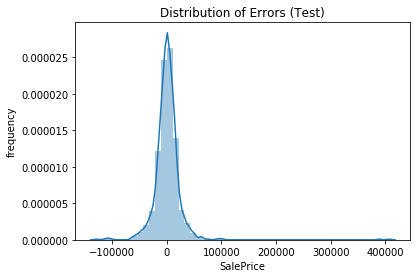

In [13]:
ax = sns.distplot(y_pred_test - y_true_test)
ax.set(title="Distribution of Errors (Test)", xlabel="SalePrice", ylabel="frequency")
plt.show()

#### As a final step, we are going to show how to use some of the [model interpretability](https://docs.microsoft.com/en-us/azure/machine-learning/service/machine-learning-interpretability-explainability) features available on Azure ML service.
#### Please notice that these are experimental features, and the supported functionality and API interfaces are still evolving.
#### Here we instantiate a ExplanationClient object, passing the best run from the job execution, to get variable feature importance scores for the engineered features (after the transformations performed automatically).

In [14]:
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=False)
print(engineered_explanations.get_feature_importance_dict())

{'Gr.Liv.Area_MeanImputer': 14919.478002641094, 'Garage.Cars_E_CharGramCountVectorizer_6': 10771.221375108407, 'Year.Built_E_MeanImputer': 7709.269591002784, 'Total.Bsmt.SF_MeanImputer': 6890.230762475651, 'Bsmt.Qual_E_CharGramCountVectorizer_6': 6589.180740781972, 'Kitchen.Qual_E_CharGramCountVectorizer_5': 4674.8524160031675, 'Fireplaces_E_CharGramCountVectorizer_1': 4646.799935821081, 'BsmtFin.SF.1_MeanImputer': 3641.1464446342084, 'X1st.Flr.SF_MeanImputer': 3333.5558039012444, 'Year.Remod.Add_E_MeanImputer': 3291.7003627924937, 'Kitchen.Qual_E_CharGramCountVectorizer_3': 2996.615749429982, 'Garage.Area_MeanImputer': 2401.349592720248, 'Garage.Cars_E_CharGramCountVectorizer_4': 2180.151052172576, 'Exter.Qual_E_CharGramCountVectorizer_3': 1991.6546058009053, 'Kitchen.Qual_E_CharGramCountVectorizer_4': 1934.4448814220411, 'Overall.Qual_E_CharGramCountVectorizer_8': 1886.3808956789958, 'X2nd.Flr.SF_MeanImputer': 1532.0033905431715, 'Lot.Area_MeanImputer': 1413.6802024245378, 'Bsmt.Expo

#### And we can do the same for the raw features.

In [15]:
client = ExplanationClient.from_run(best_run)
raw_explanations = client.download_model_explanation(raw=True)
print(raw_explanations.get_feature_importance_dict())

{'Gr.Liv.Area': 14919.478002641094, 'Garage.Cars_E': 13048.106139614025, 'Kitchen.Qual_E': 9605.91304685519, 'Year.Built_E': 7709.269591002784, 'Bsmt.Qual_E': 7194.365802030509, 'Total.Bsmt.SF': 6890.230762475651, 'Fireplaces_E': 5767.657978342275, 'Overall.Qual_E': 5431.8246782678525, 'BsmtFin.SF.1': 3641.1464446342084, 'Exter.Qual_E': 3423.7090579558794, 'X1st.Flr.SF': 3333.5558039012444, 'Year.Remod.Add_E': 3291.7003627924937, 'Garage.Area': 2401.349592720248, 'Bsmt.Exposure_E': 2219.1533838500736, 'Neighborhood_E': 1867.2419305570108, 'Overall.Cond_E': 1670.8036937337733, 'X2nd.Flr.SF': 1532.0033905431715, 'Lot.Area': 1413.6802024245378, 'BsmtFin.Type.1_E': 1306.0739815029297, 'MS.SubClass_E': 1191.1295614037485, 'Heating.QC_E': 1184.9865786484693, 'MS.Zoning_E': 1172.6745375506287, 'Bsmt.Full.Bath_E': 1161.7181354831582, 'Full.Bath_E': 1152.1459563153767, 'Lot.Shape_E': 1126.1567363647948, 'Sale.Condition_E': 1104.343146706322, 'Half.Bath_E': 1074.4096173456483, 'Wood.Deck.SF': 91

#### With that feature importance scores, we can then [visualize](https://docs.microsoft.com/en-us/azure/machine-learning/service/machine-learning-interpretability-explainability#visualizations) and interact with them to evaluate the effects of the variables on the predictions.

In [16]:
ExplanationDashboard(raw_explanations, fitted_model, X_train)

ExplanationWidget(value={'predictedY': [108711.54337938856, 93275.00826975482, 232892.15551069126, 347374.8867…

#### We can also do the same for a specific run. Azure ML service supports model interpretability and explainability in [several ways](https://docs.microsoft.com/en-us/azure/machine-learning/service/machine-learning-interpretability-explainability#how-to-interpret-your-model). Here we use a direct Mimic Explainer with a LightGBM as a surrogate model.

In [17]:
automl_run, fitted_model = local_run.get_output(iteration=0)

In [18]:
automl_explainer_setup_obj = automl_setup_model_explanations(fitted_model, X=X_train, 
                                                             X_test=X_test, y=y_train,
                                                             features=numeric_vars + categorical_vars_E,
                                                             task="regression")

Current status: Setting up data for AutoMl explanations
Current status: Setting up the AutoML featurization for explanations
Current status: Setting up the AutoML estimator
Current status: Setting up the AutoML featurizer
Current status: Generating a feature map for raw feature importance
Current status: Data for AutoMl explanations successfully setup


In [19]:
explainer = MimicWrapper(ws, automl_explainer_setup_obj.automl_estimator, LGBMExplainableModel, 
                         init_dataset=automl_explainer_setup_obj.X_transform, run=automl_run,
                         features=automl_explainer_setup_obj.engineered_feature_names, 
                         feature_maps=[automl_explainer_setup_obj.feature_map],
                         classes=automl_explainer_setup_obj.classes)

In [20]:
engineered_explanations = explainer.explain(['local', 'global'], eval_dataset=automl_explainer_setup_obj.X_test_transform)
print(engineered_explanations.get_feature_importance_dict())
ExplanationDashboard(engineered_explanations, automl_explainer_setup_obj.automl_estimator, automl_explainer_setup_obj.X_test_transform)

{'Gr.Liv.Area_MeanImputer': 18161.819858927774, 'Garage.Cars_E_CharGramCountVectorizer_6': 11792.282244881184, 'Bsmt.Qual_E_CharGramCountVectorizer_6': 7305.538572671776, 'Year.Built_E_MeanImputer': 7254.143542372315, 'Total.Bsmt.SF_MeanImputer': 6665.344011359633, 'Year.Remod.Add_E_MeanImputer': 4062.692235283046, 'BsmtFin.SF.1_MeanImputer': 3503.179369023099, 'Kitchen.Qual_E_CharGramCountVectorizer_5': 3082.1742183853253, 'X1st.Flr.SF_MeanImputer': 2608.196749672878, 'Fireplaces_E_CharGramCountVectorizer_1': 2478.1226123026327, 'Garage.Cars_E_CharGramCountVectorizer_4': 2340.7122571627874, 'Overall.Qual_E_CharGramCountVectorizer_8': 2291.159030845717, 'Fireplaces_E_CharGramCountVectorizer_3': 1733.027185778433, 'BsmtFin.Type.1_E_CharGramCountVectorizer_7': 1691.2636943122247, 'Bsmt.Exposure_E_CharGramCountVectorizer_5': 1568.3682185553707, 'X2nd.Flr.SF_MeanImputer': 1507.5544977857687, 'Lot.Area_MeanImputer': 1491.5122581500113, 'Exter.Qual_E_CharGramCountVectorizer_2': 1424.40521569

ExplanationWidget(value={'predictedY': [135150.60044871218, 77716.74454212261, 171209.79099367248, 128721.1659…

In [22]:
raw_explanations = explainer.explain(['local', 'global'], get_raw=True, 
                                     raw_feature_names=automl_explainer_setup_obj.raw_feature_names,
                                     eval_dataset=automl_explainer_setup_obj.X_test_transform)
print(raw_explanations.get_feature_importance_dict())

{'Gr.Liv.Area': 18161.819858927774, 'Garage.Cars_E': 14217.225463895073, 'Bsmt.Qual_E': 7742.113549629819, 'Year.Built_E': 7254.143542372315, 'Total.Bsmt.SF': 6665.344011359633, 'Overall.Qual_E': 6055.753685863843, 'Kitchen.Qual_E': 5597.10270095154, 'Fireplaces_E': 4257.897897668953, 'Year.Remod.Add_E': 4062.692235283046, 'Exter.Qual_E': 3528.1552066561308, 'BsmtFin.SF.1': 3503.179369023099, 'Bsmt.Exposure_E': 3271.6691653824373, 'Neighborhood_E': 2817.3312895073805, 'Overall.Cond_E': 2721.7190941150097, 'X1st.Flr.SF': 2608.196749672878, 'BsmtFin.Type.1_E': 1905.9626274656207, 'MS.Zoning_E': 1542.8307844276853, 'X2nd.Flr.SF': 1507.5544977857687, 'Lot.Area': 1491.5122581500113, 'Garage.Type_E': 1297.818590430366, 'Sale.Condition_E': 1272.4286674242899, 'Heating.QC_E': 1238.1065438453902, 'Garage.Area': 1165.0218439417379, 'Bsmt.Full.Bath_E': 1132.4723217456599, 'Half.Bath_E': 1119.5782721626742, 'MS.SubClass_E': 1044.80198329854, 'Mas.Vnr.Area': 1008.3779690997318, 'Condition.1_E': 963

In [23]:
ExplanationDashboard(raw_explanations, automl_explainer_setup_obj.automl_pipeline, automl_explainer_setup_obj.X_test_raw)

ExplanationWidget(value={'predictedY': [135150.60044871218, 77716.74454212261, 171209.79099367248, 128721.1659…